In [1]:
import xarray as xr
import glob
import numpy as np
import pandas as pd
import pyproj
import sys
sys.path.append('..')
from libs.util.geo_spatial import transform_coordinates
import matplotlib.pyplot as plt

# load data from archive

In [2]:
# load soilnet data
ds = xr.open_dataset("../../../data/soilnet/soilnet_prepreproc.nc").load()
# load the metadata
metadata = pd.read_csv("../../../data/soilnet/CHS_Measurements_SoilNet_only.csv", encoding= 'unicode_escape')
# drop rows and columns if all entries are nan
for axis in [0, 1]:
    metadata = metadata.dropna(axis=axis, how='all')

# Investigate the data

In [3]:
metadata.columns

Index(['variable description', 'depth/height (m)', 'SoilNet Node',
       'Soilnet Sensor', 'Naming', 'headerout', 'units', 'headerout (final)',
       'headerout (DB)', 'database ID', 'Min', 'Max', 'SR collar or trench',
       'date start', 'date end', '(rough) distance from collar', 'remarks',
       'coordinates x', 'coordinates y',
       'max percentage missing data for aggregation resulting in flag 1',
       'max percentage missing data for aggregation resulting in flag 2',
       'Flag_0', 'Flag_1', 'Flag_2', 'Flag_3', 'Flag_4', 'Alert_1', 'Alert_2',
       'Alert_3', 'comment', 'old Flag_6', 'old Flag_4', 'old Flag_5',
       'old Flag_7'],
      dtype='object')

In [4]:
# drop rows where sensor_id ist nan
metadata = metadata.dropna(subset=['Soilnet Sensor'])
metadata

,variable description,depth/height (m),SoilNet Node,Soilnet Sensor,Naming,headerout,units,headerout (final),headerout (DB),database ID,...,Flag_3,Flag_4,Alert_1,Alert_2,Alert_3,comment,old Flag_6,old Flag_4,old Flag_5,old Flag_7
0,soil water content 0.05m 1/1,0.05,1.0,1.0,Box01_Moist1,Box01_Moist1,%,Box01_Moist1 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,soil water content 0.05m 1/2,0.05,1.0,2.0,Box01_Moist2,Box01_Moist2,%,Box01_Moist2 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soil water content 0.05m 1/3,0.05,1.0,3.0,Box01_Moist3,Box01_Moist3,%,Box01_Moist3 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,soil water content 0.05m 1/4,0.05,1.0,4.0,Box01_Moist4,Box01_Moist4,%,Box01_Moist4 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,soil water content 0.05m 1/5,0.05,1.0,5.0,Box01_Moist5,Box01_Moist5,%,Box01_Moist5 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,soil water content 0.1m 40/2,0.10,40.0,2.0,SWC 0.1m 40/2 SR7,Box40_Moist2,%,Box40_Moist2 [%],SoilSoilmoisture0_1mAvg15Min_40_2,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d
272,soil water content 0.1m 40/3,0.10,40.0,3.0,SWC 0.1m 40/3 SR8,Box40_Moist3,%,Box40_Moist3 [%],SoilSoilmoisture0_1mAvg15Min_40_3,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d
273,soil water content 0.3m 40/4,0.30,40.0,4.0,SWC 0.3m 40/4 SR8,Box40_Moist4,%,Box40_Moist4 [%],SoilSoilmoisture0_3mAvg15Min_40_4,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d
274,soil water content 0.1m 40/5,0.10,40.0,5.0,SWC 0.1m 40/5 SR9,Box40_Moist5,%,Box40_Moist5 [%],SoilSoilmoisture0_1mAvg15Min_40_5,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,11.3.15: moved by 2.5m north,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d



The new dataset was created based on the data set soilnet_prepreproc.nc which was generated bu Julius some time ago. For this data a coordinate sensor_id was generated to uniquely identify each sensor. I assumed that these sensor_id was consecutively generated from the two variables SoilNet Node and Soilnet Sensor. Since the first node has no values, it stats with sensor_id=0 for the SoilNet Node=2 and Soilnet Sensor=0.

sensor_id=1 for the SoilNet Node=2 and Soilnet Sensor=1

sensor_id=2 for the SoilNet Node=2 and Soilnet Sensor=2

sensor_id=3 for the SoilNet Node=2 and Soilnet Sensor=3

...

sensor_id=7 for the SoilNet Node=3 and Soilnet Sensor=1

sensor_id=8 for the SoilNet Node=3 and Soilnet Sensor=2

...

Sensor depth are:
[0.05 0.1  0.2  0.3  0.4  0.5  0.6 ]


/var/folders/6l/0s4z490s6g7crj6_grh7n6fh0000gp/T/ipykernel_92156/1810927709.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


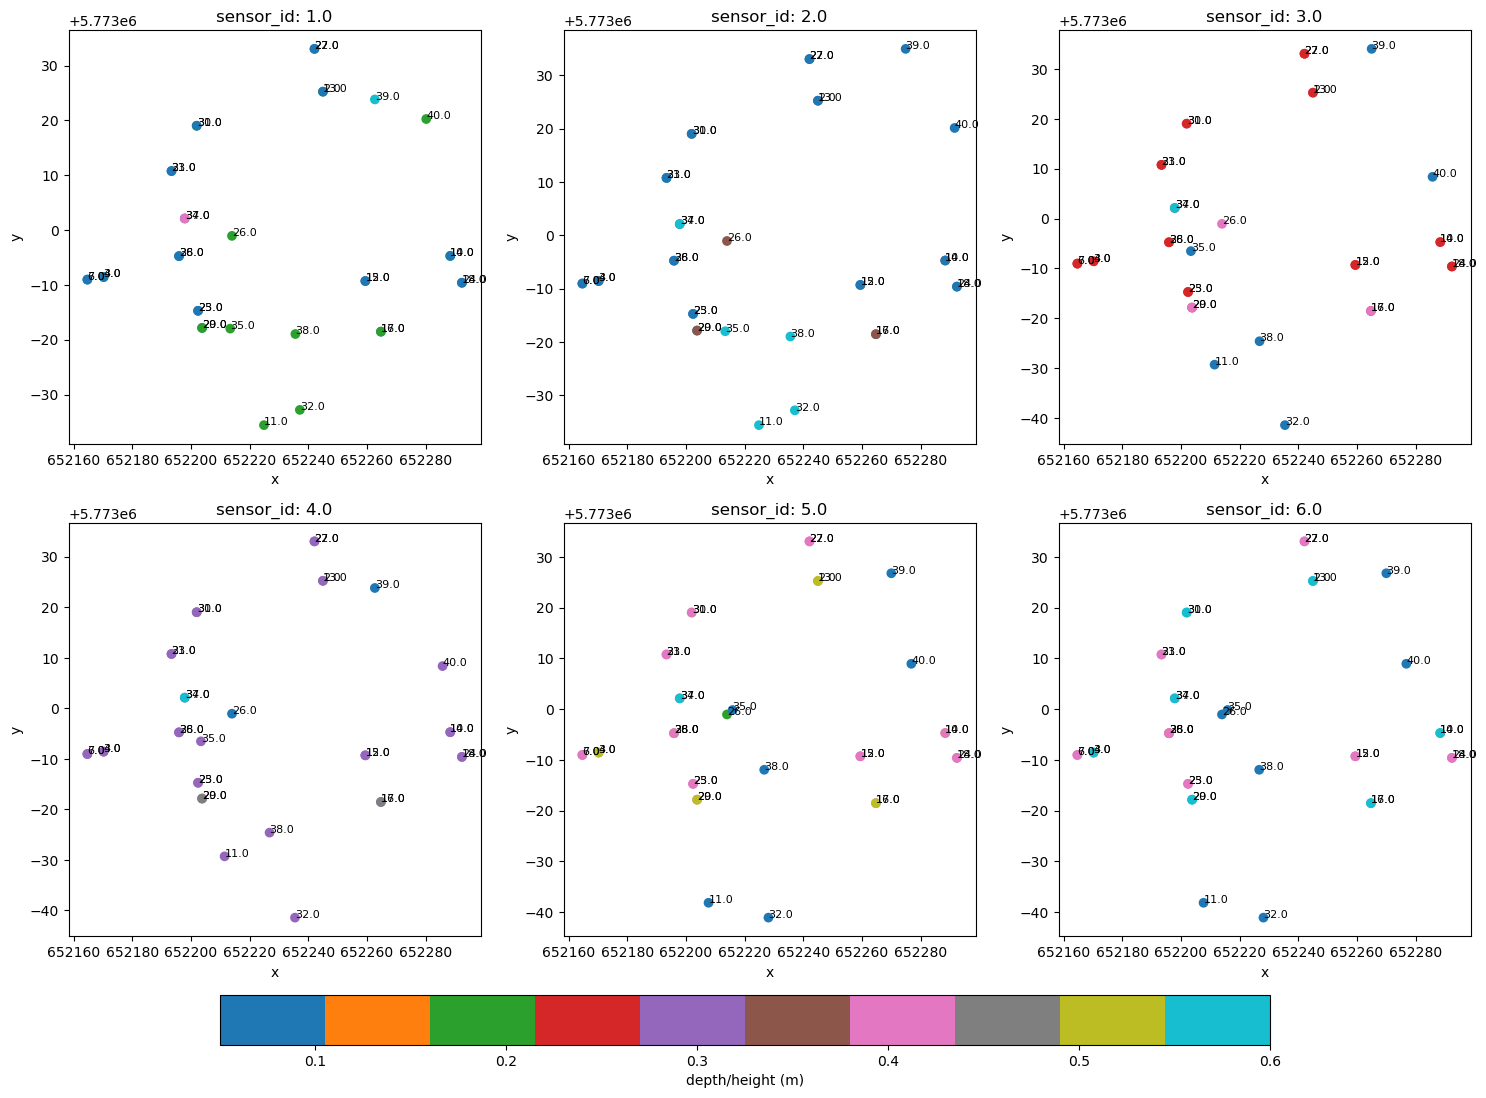

In [5]:
# visualize the sensors in a scatter plot and color them according to the soil depth, make one sub plot for each of the 6 sensor_ids
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
print('Sensor depth are:')
print(metadata['depth/height (m)'].unique())

coordinates = []
for i, sensor_id in enumerate(metadata['Soilnet Sensor'].unique()):
    metadata_sensor_id = metadata[metadata['Soilnet Sensor'] == sensor_id]
    # append the coordinates as tuple of x, y to the list
    coordinates.append((metadata_sensor_id['coordinates x'].values, metadata_sensor_id['coordinates y'].values))
    axs[i].scatter(metadata_sensor_id['coordinates x'], metadata_sensor_id['coordinates y'], c=metadata_sensor_id['depth/height (m)'], cmap="tab10")
    axs[i].set_title(f"sensor_id: {sensor_id}")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    # label the points with the Soilnet Node
    for j, txt in enumerate(metadata_sensor_id['SoilNet Node']):
        axs[i].annotate(txt, (metadata_sensor_id['coordinates x'].values[j], metadata_sensor_id['coordinates y'].values[j]), fontsize=8)
        
# add horizontal colorbar below the subplots 
cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.05])
normalize = plt.Normalize(vmin=np.min(metadata['depth/height (m)']), vmax=np.max(metadata['depth/height (m)']))
sm = plt.cm.ScalarMappable(cmap="tab10", norm=normalize)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", label="depth/height (m)")
plt.tight_layout()


In [6]:
# check if for a soilnet node the coordinates are the same for all sensors of that node
for node in metadata['SoilNet Node'].unique():
    metadata_node = metadata[metadata['SoilNet Node'] == node]
    if len(metadata_node['coordinates x'].unique()) > 1 or len(metadata_node['coordinates y'].unique()) > 1:
        print(f"node {node} has different coordinates")
        print(metadata_node[['SoilNet Node', 'Soilnet Sensor', 'coordinates x', 'coordinates y']])

node 11.0 has different coordinates
    SoilNet Node  Soilnet Sensor  coordinates x  coordinates y
66          11.0             1.0  652224.847377   5.772964e+06
67          11.0             2.0  652224.847377   5.772964e+06
68          11.0             3.0  652211.415446   5.772971e+06
69          11.0             4.0  652211.415446   5.772971e+06
70          11.0             5.0  652207.650749   5.772962e+06
71          11.0             6.0  652207.650749   5.772962e+06
node 32.0 has different coordinates
     SoilNet Node  Soilnet Sensor  coordinates x  coordinates y
214          32.0             1.0  652237.087026   5.772967e+06
215          32.0             2.0  652237.087026   5.772967e+06
216          32.0             3.0  652235.422794   5.772959e+06
217          32.0             4.0  652235.422794   5.772959e+06
218          32.0             5.0  652228.077946   5.772959e+06
219          32.0             6.0  652228.077946   5.772959e+06
node 35.0 has different coordinates
   

In [7]:
metadata

,variable description,depth/height (m),SoilNet Node,Soilnet Sensor,Naming,headerout,units,headerout (final),headerout (DB),database ID,...,Flag_3,Flag_4,Alert_1,Alert_2,Alert_3,comment,old Flag_6,old Flag_4,old Flag_5,old Flag_7
0,soil water content 0.05m 1/1,0.05,1.0,1.0,Box01_Moist1,Box01_Moist1,%,Box01_Moist1 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,soil water content 0.05m 1/2,0.05,1.0,2.0,Box01_Moist2,Box01_Moist2,%,Box01_Moist2 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soil water content 0.05m 1/3,0.05,1.0,3.0,Box01_Moist3,Box01_Moist3,%,Box01_Moist3 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,soil water content 0.05m 1/4,0.05,1.0,4.0,Box01_Moist4,Box01_Moist4,%,Box01_Moist4 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,soil water content 0.05m 1/5,0.05,1.0,5.0,Box01_Moist5,Box01_Moist5,%,Box01_Moist5 [%],NaN,NaN,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,soil water content 0.1m 40/2,0.10,40.0,2.0,SWC 0.1m 40/2 SR7,Box40_Moist2,%,Box40_Moist2 [%],SoilSoilmoisture0_1mAvg15Min_40_2,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d
272,soil water content 0.1m 40/3,0.10,40.0,3.0,SWC 0.1m 40/3 SR8,Box40_Moist3,%,Box40_Moist3 [%],SoilSoilmoisture0_1mAvg15Min_40_3,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d
273,soil water content 0.3m 40/4,0.30,40.0,4.0,SWC 0.3m 40/4 SR8,Box40_Moist4,%,Box40_Moist4 [%],SoilSoilmoisture0_3mAvg15Min_40_4,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,NaN,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d
274,soil water content 0.1m 40/5,0.10,40.0,5.0,SWC 0.1m 40/5 SR9,Box40_Moist5,%,Box40_Moist5 [%],SoilSoilmoisture0_1mAvg15Min_40_5,86affd92630cb,...,limits,Spike thresh=1 toler=0.3 length=60,NaN,NaN,NaN,11.3.15: moved by 2.5m north,constant length=5h eps=0.0001,install_date,compare_precip rise_thres=8.0/h prec_thres=0.1...,MAD deriv=2 z=7 length=180d


# Start Processing

In [8]:
# take metadata['coordinates x'] and metadata['coordinates y'] and transform them to lat/lon
# define the projection
epsg_in = '32632' # UTM 32N
epsg_out = '4326' # WGS84
# transform the coordinates
metadata['lon'], metadata['lat'] = transform_coordinates(metadata['coordinates x'].values, metadata['coordinates y'].values, epsg_in, epsg_out)
metadata.rename(columns={'SoilNet Node':'box_id', 'Soilnet Sensor':'level_id', 'depth/height (m)':'depth'}, inplace=True)
# remove rows where level_id is nan
metadata = metadata[~metadata['level_id'].isna()]
# check if tuples of box_id and level_id are unique
metadata[['box_id', 'level_id']].duplicated().sum()
# check which box_id and level_id tuples are duplicated
metadata[metadata[['box_id', 'level_id']].duplicated()]
# drop duplicates
metadata = metadata.drop_duplicates(subset=['box_id', 'level_id'])
# remove all columns except for box_id, level_id, lat, lon
metadata = metadata[['box_id', 'level_id', 'lat', 'lon', 'depth']]
# remove all rows where box_id is 1.0
metadata = metadata[metadata['box_id'] != 1.0]
# get the sensor_ids, box_ids and level_ids from the ds data
sensor_ids = ds['sensor_id'].values
box_ids = ds['box_id'].values
level_ids = ds['level_id'].values
# use the sensor_ids, box_ids and level_ids to create a new column in the metadata called sensor_id
metadata['sensor_id'] = [sensor_ids[np.where((box_ids == box_id) & (level_ids == level_id))][0] for box_id, level_id in zip(metadata['box_id'].values, metadata['level_id'].values)]
# assign coordinates to the ds based on lat and lon from the metadata
ds = ds.assign_coords(
    {
        "latitude": (("sensor_id"), metadata["lat"].values),
        "longitude": (("sensor_id"), metadata["lon"].values),
    }
)
# assign depth/height (m) to the ds based on the metadata
ds = ds.assign_coords(
    {
        "depth": (("sensor_id"), metadata["depth"].values),
    }
)

ds

/Users/houben/micromamba/envs/resead/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/houben/micromamba/envs/resead/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/houben/phd/studies/030-resead/repo/experiment_pipeline/notebooks/../libs/util/geo_spatial.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.

<xarray.Dataset>
Dimensions:                   (time: 302043, sensor_id: 234)
Coordinates:
  * time                      (time) datetime64[ns] 2010-09-30T02:00:00 ... 2...
  * sensor_id                 (sensor_id) int64 0 1 2 3 4 ... 230 231 232 233
    box_id                    (sensor_id) int64 2 2 2 2 2 2 ... 40 40 40 40 40
    level_id                  (sensor_id) int64 1 2 3 4 5 6 1 ... 6 1 2 3 4 5 6
    latitude                  (sensor_id) float64 52.09 52.09 ... 52.09 52.09
    longitude                 (sensor_id) float64 11.22 11.22 ... 11.22 11.22
    depth                     (sensor_id) float64 0.1 0.2 0.3 ... 0.3 0.1 0.3
Data variables: (12/25)
    moisture                  (sensor_id, time) float64 nan nan ... 45.43 45.43
    temp                      (sensor_id, time) float64 nan nan ... 7.928 7.928
    battv                     (sensor_id, time) float64 nan nan ... 3.392e+03
    moisture_nb0              (sensor_id, time) float64 nan nan ... -13.03
    temp_nb0                  (sensor_id, time) float64 nan nan ... -18.37
    moisture_nb1              (sensor_id, time) float64 nan nan nan ... nan nan
    ...                        ...
    temp_flag_no_label        (sensor_id, time) bool True True ... False False
    temp_flag_Auto:BattV      (sensor_id, time) bool False False ... False False
    temp_flag_Auto:Range      (sensor_id, time) bool False False ... False False
    temp_flag_Auto:Spike      (sensor_id, time) bool False False ... False False
    temp_flag_Manual          (sensor_id, time) bool False False ... False False
    temp_flag_OK              (sensor_id, time) bool False False ... True True

In [9]:
# check how many nan are in the flags series
nans = []
flag_variables = []
for k in ds.keys():
    if 'flag' in k:
        flag_variables.append(k)
        print('Number of nan in ' + k + ': ' + str(np.sum(np.isnan(ds[k]))))
        nans.append(np.sum(np.isnan(ds[k])))

if np.all(nans) == 0:
    print('No nan in flags series. Data set is fully labelled.')

# %%
# check the number of unique values in the series
np.unique(ds['moisture_flag_no_label'], return_counts=True)
np.unique(ds['temp_flag_no_label'], return_counts=True)
# check if the series no_label and OK are complementary
complementary = ds['moisture_flag_no_label'] == ~ds['moisture_flag_OK']
np.unique(complementary, return_counts=True)

Number of nan in moisture_flag_no_label: <xarray.DataArray 'moisture_flag_no_label' ()>
array(0)
Number of nan in moisture_flag_Auto:BattV: <xarray.DataArray 'moisture_flag_Auto:BattV' ()>
array(0)
Number of nan in moisture_flag_Auto:Range: <xarray.DataArray 'moisture_flag_Auto:Range' ()>
array(0)
Number of nan in moisture_flag_Auto:Spike: <xarray.DataArray 'moisture_flag_Auto:Spike' ()>
array(0)
Number of nan in moisture_flag_Manual: <xarray.DataArray 'moisture_flag_Manual' ()>
array(0)
Number of nan in moisture_flag_OK: <xarray.DataArray 'moisture_flag_OK' ()>
array(0)
Number of nan in temp_flag_no_label: <xarray.DataArray 'temp_flag_no_label' ()>
array(0)
Number of nan in temp_flag_Auto:BattV: <xarray.DataArray 'temp_flag_Auto:BattV' ()>
array(0)
Number of nan in temp_flag_Auto:Range: <xarray.DataArray 'temp_flag_Auto:Range' ()>
array(0)
Number of nan in temp_flag_Auto:Spike: <xarray.DataArray 'temp_flag_Auto:Spike' ()>
array(0)
Number of nan in temp_flag_Manual: <xarray.DataArray '

(array([False,  True]), array([13248087, 57429975]))

In [10]:
# drop irrelevant variables based on which ones we want to keep
current_vars = list(ds.keys())
keep_vars = ["moisture", "temp", "battv"] + flag_variables
ds = ds.drop(list(set(current_vars) - set(keep_vars)))


In [11]:
ds

<xarray.Dataset>
Dimensions:                   (time: 302043, sensor_id: 234)
Coordinates:
  * time                      (time) datetime64[ns] 2010-09-30T02:00:00 ... 2...
  * sensor_id                 (sensor_id) int64 0 1 2 3 4 ... 230 231 232 233
    box_id                    (sensor_id) int64 2 2 2 2 2 2 ... 40 40 40 40 40
    level_id                  (sensor_id) int64 1 2 3 4 5 6 1 ... 6 1 2 3 4 5 6
    latitude                  (sensor_id) float64 52.09 52.09 ... 52.09 52.09
    longitude                 (sensor_id) float64 11.22 11.22 ... 11.22 11.22
    depth                     (sensor_id) float64 0.1 0.2 0.3 ... 0.3 0.1 0.3
Data variables: (12/15)
    moisture                  (sensor_id, time) float64 nan nan ... 45.43 45.43
    temp                      (sensor_id, time) float64 nan nan ... 7.928 7.928
    battv                     (sensor_id, time) float64 nan nan ... 3.392e+03
    moisture_flag_no_label    (sensor_id, time) bool True True ... False False
    moisture_flag_Auto:BattV  (sensor_id, time) bool False False ... False False
    moisture_flag_Auto:Range  (sensor_id, time) bool False False ... False False
    ...                        ...
    temp_flag_no_label        (sensor_id, time) bool True True ... False False
    temp_flag_Auto:BattV      (sensor_id, time) bool False False ... False False
    temp_flag_Auto:Range      (sensor_id, time) bool False False ... False False
    temp_flag_Auto:Spike      (sensor_id, time) bool False False ... False False
    temp_flag_Manual          (sensor_id, time) bool False False ... False False
    temp_flag_OK              (sensor_id, time) bool False False ... True True

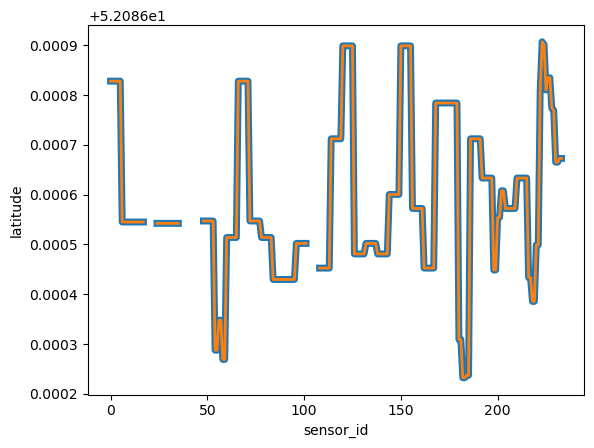

In [12]:
# check if the lat lon have been assigned correctly
metadata.set_index('sensor_id', inplace=True)
ds['latitude'].plot(linewidth=5)
metadata['lat'].plot(linewidth=2)
plt.show()

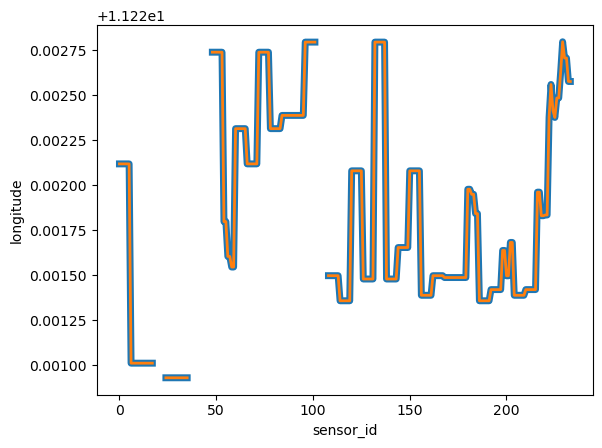

In [13]:
ds['longitude'].plot(linewidth=5)
metadata['lon'].plot(linewidth=2)
plt.show()

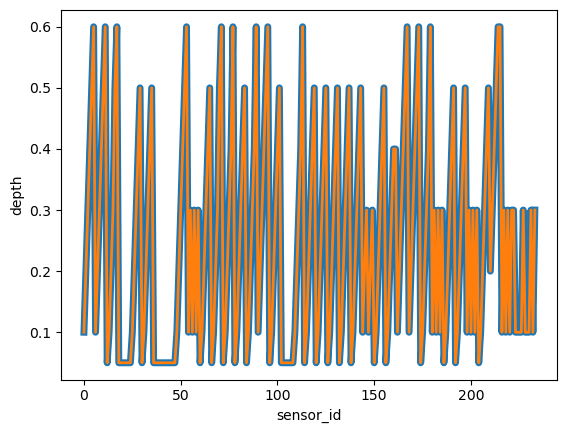

In [14]:
# check if the sensor depth has been correctly assigned
metadata['depth'].plot(linewidth=5)
ds['depth'].plot(linewidth=2)

In [15]:
ds.to_netcdf('../../../data/soilnet/proc_soilnet_prepreproc.nc')